# LAND PRICE PREDICTION APP USING AWS SAGEMAKER - End-to-End
We will build a Land Price Prediction App to help people looking to buy land in Cameroon, get the expected price per quartier they intend to buy land from.
As seen in the Best Practices for Machine Learning Projects on AWS, the following steps will be taken:
- I)   PROBLEM STATEMENT:

Many people in Cameroon want to buy lands and they have trouble getting informatoon of what to expect as price per suare metre for the quartier they want to buy the land in.They also want to be able to consult the prices of several quartiers before making their choice.
This is a difficult process in Cameroon as it will mean these people who want to buy lands will have to go about making phone calls and asking pople what are the prices of lands in different areas.
So the objective is to scrape the data already available on the biggest Classified adds website in Cameroon (Jumia Cameroon) https://www.jumia.cm/en/land-plots

This data will be cleaned and trained using the in-built XGBoost Algorithm on AWS Sagemaker, and an endpoint will be created in AWS ,which wll be used to make predictions when given the inputs like 
- The Quartier the customer wants to buy land from
- The size of the land the customer intends to buy (in metres square)
- And the outputt of the model will be the predicted Price per metre square for the Quartier the customer requested.


- II)   SCRAPING THE DATA:

Scrape the data from a Classified ads website, where people post lands for sale per quartier in Cameroon.They typically type in the price per metres square and the total area of the land availlable for sale
- III)  PERFORM EXPLORATORY DATA ANALYSIS 

Inspect the data to validate the quality of the data scraped from the classified ads website.See the distribution of missing values, outliers and gain other insight which will be used in the Feature Engineering stage to better prepare the features for the machine learning model to be able to make accurate predictions.
- IV) DO FEATURE ENGINEERING & SELECTION

Handle the mising values, outliers and do the necessary transformations which will ensure the data is well suited for the machine learning model.And also to maximise the insights gotten from the Exploratory Data Analysis phase.
- V)  BUILD,TRAIN AND DEPLOY THE MODEL IN SAGEMAKER

The Boto3 Container will be used to create the S3 buckets to store the preprocessed dataset.The Sagemaker's inbuilt XGBoost algorithm, will be built, trained and deployed.Including the use of optimal hyperparameters to get the best results for the RMSE( Root Mean Squared Error).An Endpoint will be created after the model is built.

- VI)   MODEL INFERENCE IN SAGEMAKER

The Endpoint created above will be used to predict the price per metre square when the inputs of "Quartier" and "Land size" are entered.

### III) EXPLORATORY DATA ANALYSIS
We will perform the following tasks in order to successfully complete the EDA
- a.) Importing the necessary Libraries and scraped data
- b.) Inspecting Missing Values
- c.) Inspecting the Numeric Variable
- d.) Inspecting the Categorical Variables
- e.) Inspecting other relationships

#### a.) Importing the necessary Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [39]:
#import the scraped data and view the first 10 observations
dataset = pd.read_csv('land_price3_formatted.csv',index_col = 0)
print(dataset.head(10))

      Price    Location      Area
0      8000      Douala   10000.0
1     55000       Yassa     300.0
2     55000       Yassa     200.0
3     55000      Japoma     735.0
4     55000      Japoma    1500.0
5      3000        Mfou  174000.0
6  16000000  Biyem-Assi     270.0
7     60000       Kribi    5000.0
8    150000       Kribi    1000.0
9      8000      Douala   10000.0


From here, we can already see that there is some inconsistency in how the data was entered in the classified adds website.

Line 6  above (Biyem-Assi) clearly shows that the correct value for price would have been "16000000 /270 = 59259".

So some data in the Price column are entered as "Price Per Metres Square"( Like "Yassa", "Japoma","Kribi" ), while some are entered as total of "Price per m2" * "Total Area" (like the case for the Location "Biyem-Assi" in Line 6).

Also "Douala" is city and not a quartier.These cities will have to be removed in the feature engineering stage, since the model only has to predict prices for neighbourhoods and not cities.

This will need to be taken care of in the feature Engineering stage.

#### b.) Inspecting Missing Values

In [40]:
#Create a function to check for missing values in the dataset
features_with_na = [feature for feature in dataset.columns if dataset[feature].isnull().sum()>1]

for feature in features_with_na:
    print(feature, np.round(dataset[feature].isnull().mean(),2),'% missing values' )

Area 0.05 % missing values


<AxesSubplot:>

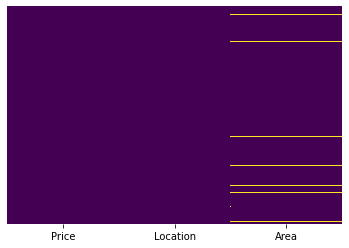

In [41]:
#Plotting a heatmap to visualise the missing values
sns.heatmap(dataset.isnull(),yticklabels=False,cbar=False,cmap='viridis')

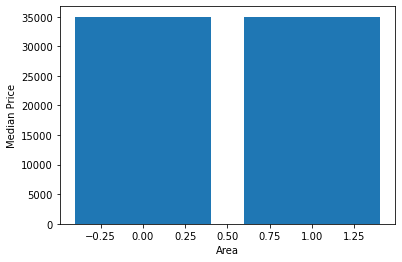

In [42]:
#Plot to see if Area containing missing values Vs Area not Containing Missing Values have any correlation with Price
data = dataset.copy()
data['Area'] = np.where(data['Area'].isnull(),1,0)
plt.bar(data['Area'],data['Price'].median())
plt.xlabel('Area')
plt.ylabel('Median Price')
plt.show()

It shows that the missing values in Area column have no relationship with the Price of the land.So we could drop them off with no issues later when doing the feature engineering. 

#### c.) i.) Inspecting the Numeric Variables - Price

In [43]:
print(dataset['Price'].describe())

count    4.490000e+03
mean     4.961029e+07
std      8.482607e+08
min      0.000000e+00
25%      1.000000e+04
50%      3.500000e+04
75%      5.000000e+05
max      4.500000e+10
Name: Price, dtype: float64


We see that the mean is 49 610 290, while the median is 35 000.The difference is very huge.We will have a lot of work to do with the outliers.

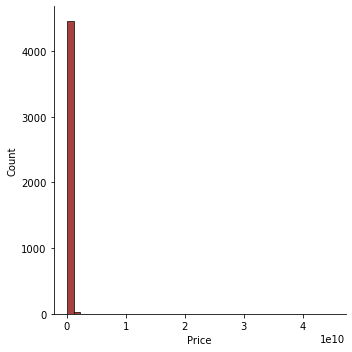

In [44]:
#Plot to see the distribution of Price
sns.displot(dataset['Price'].dropna(),kde=False,color='darkred',bins=40)

We see from the distribution plot above that there are just few outliers causing the trouble.
Now let us take a look at the dataset above the 3rd Quartile (75 percentile).

In [45]:
data = dataset.copy();
data_outlier = data[data['Price'] > data['Price'].quantile(0.75)]
print(data_outlier.head(10))

        Price      Location    Area
6    16000000    Biyem-Assi   270.0
16   60000000        Logpom  1000.0
17   57240000    Omnisports   477.0
19   21875000         Yassa   875.0
20   26000000        Logpom   200.0
21  200000000  Bonamoussadi   300.0
22   12000000          PK12   300.0
23    3000000         Lendi   500.0
24   34000000        Makepe   340.0
25   24000000        Logpom   200.0


Let us divide "Price" by "Area" and see if the result will be close to the median.

In [46]:
data_outlier['Price per Area'] = data_outlier['Price']/ data_outlier['Area']

<ipython-input-46-cbb84c82a8c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_outlier['Price per Area'] = data_outlier['Price']/ data_outlier['Area']


In [47]:
print(data_outlier.head(10))

        Price      Location    Area  Price per Area
6    16000000    Biyem-Assi   270.0    59259.259259
16   60000000        Logpom  1000.0    60000.000000
17   57240000    Omnisports   477.0   120000.000000
19   21875000         Yassa   875.0    25000.000000
20   26000000        Logpom   200.0   130000.000000
21  200000000  Bonamoussadi   300.0   666666.666667
22   12000000          PK12   300.0    40000.000000
23    3000000         Lendi   500.0     6000.000000
24   34000000        Makepe   340.0   100000.000000
25   24000000        Logpom   200.0   120000.000000


The price per Area looks Great!!!
It shows that most of these values were wrongly entered like we suspected.The minimum Price Per Area is 6000,while the maximum is 130 000.Which are all reasonable.
We will do this correction during Feature Engineering.

Let's just take a look at the distribution without the outliers.

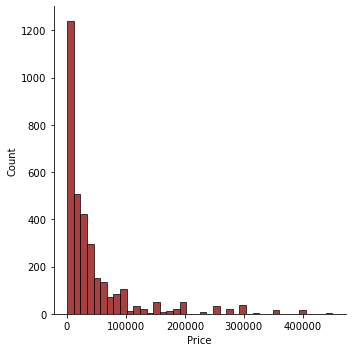

In [48]:
data_without_outlier = data[data['Price'] < data['Price'].quantile(0.75)]
sns.displot(data_without_outlier['Price'].dropna(),kde=False,color='darkred',bins=40)

We see that without the outliers it looks better now.We will come back to these later in the feature engineering phase.But now it is good we have an idea of the distribution of our dataset and things we could possibly do later to improve accuracy.

#### c.) ii.) Inspecting the Numeric Variables - Area 

In [49]:
#Summary descriptive stats
print(dataset['Area'].describe())

count      4270.000000
mean      10036.810304
std       42361.933909
min           0.000000
25%         500.000000
50%        1000.000000
75%        5393.750000
max      500000.000000
Name: Area, dtype: float64


We notice that the mean is 10 036, while the median is 1 000.Again there are lots of outliers which we will need to take care of later.

Let us look at the distribution

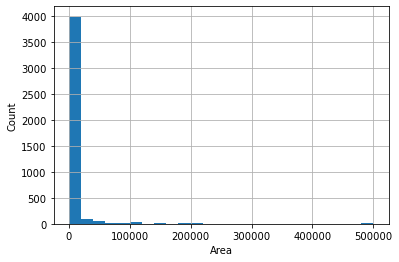

In [50]:
#Plotting a box plot to view the dispersion
data = dataset.copy()
data['Area'].hist(bins=25)
plt.xlabel('Area')
plt.ylabel('Count')
plt.show()

Again it confirms that a few points are making the distribution very positively skewed.We will also deal with them later.
Next let us look at the relationship between Area and price.We need to confirm if the "Price" will increase per "Area" or it would be a uniform distribution.

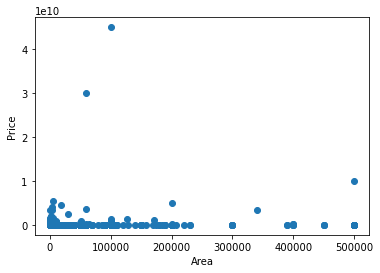

In [51]:
#Find relationship between Area and Price
data = dataset.copy()
plt.scatter(data['Area'],data['Price'])
plt.xlabel('Area')
plt.ylabel('Price')

plt.show()

It shows a somewhat uniform distribution if we take care of the outliers in "Price". It is good to know that most of the price was entered as "Price per metres squared" and not as "Price per metres squared * metres squares".

##### d.) Inspecting Location

<AxesSubplot:xlabel='Location', ylabel='count'>

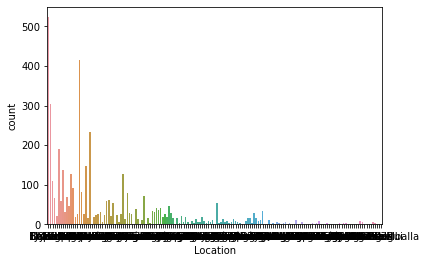

In [52]:
#Looking at the distribution of Location
sns.countplot(x='Location',data = dataset)

In [53]:
print(f"The number of categories in the Location variable is : {dataset['Location'].nunique()} locations  \n ")
print(dataset['Location'].unique())

The number of categories in the Location variable is : 161 locations  
 
['Douala' 'Yassa' 'Japoma' 'Mfou' 'Biyem-Assi' 'Kribi' 'Bastos' 'Logpom'
 'Omnisports' 'Bonamoussadi' 'PK12' 'Lendi' 'Makepe' 'PK11' 'Zone Bassa'
 'Yaoundé' 'Kotto' 'Mendong' 'Logbessou' 'Nyom2' 'Odza' 'Mbankolo' 'Nyom'
 'Mimboman' 'Nkolfoulou' 'Nkolbisson' 'Mbangue' 'PK26' 'Soa' 'PK21'
 'Ndog-Bong' 'Village' 'Bonedale' 'Bassa' 'Manjo' 'PK27' 'Limbé' 'Ndokoti'
 'Bonaberi' 'Akwa' 'Centre ville' 'Tiko' 'Ahala' 'Emana' 'Oyom Abang'
 'Logbaba' 'Nkoabang' 'Santa Barbara' 'Tsinga' 'Zamengoue' 'PK33' 'PK19'
 'Awae' 'Olembe' 'Edéa' 'Denver' 'Cite des Palmiers' 'Bonanjo' 'PK16'
 'Nyalla' 'Messassi' 'PK15' 'Beedi' 'Foumbot' 'Dibombari' 'Bepanda'
 'Quartier Golf' 'Bali' 'Nlongkak' 'Mbalgong' 'Elig-Essono' 'Damase'
 'Ange Raphael' 'Obobogo' 'Efoulan' 'Essos' 'Mbanga' 'Mvog Ada' 'Nyom1'
 'Mvan' 'Nkondengui' 'Bonapriso' 'Bafoussam' 'Eleveur' 'Buea' 'Cité Sic'
 'PK18' 'Ekié' 'Ndogpassi2' 'PK20' 'Ngoumou' 'Ekounou' 'Mbalmayo' 'Pk

There are too many categories and this would make the data very sparse when we will do oneHot encoding later.We might decide to build several models per city and so each city has a list of its neighbourhoods only.We do not want the dataset to become too wide after onehot encoding.

In [51]:
print(dataset['Location'].value_counts())

Douala        523
Yaoundé       414
Yassa         303
Odza          234
Kribi         191
             ... 
Mokolo          1
Messa           1
Mbengwi         1
Oyom Abang      1
Ngodi           1
Name: Location, Length: 161, dtype: int64


Douala and Yaoundé are Cities, so we will need to drop them off from the dataset. and focus on the neighbourhoods in these cities.Surely those were wrong entries for the Locations when they were listing the lands for sale.

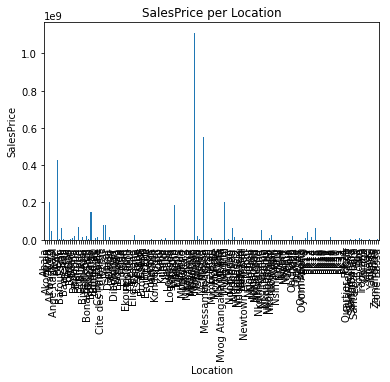

In [36]:
data = dataset.copy()
data.groupby('Location')['Price'].median().plot.bar()
plt.xlabel('Location')
plt.ylabel('SalesPrice')
plt.title('SalesPrice per Location')
plt.show()

Again, we need to take care of the outliers in the "Price" column and it would be OK.

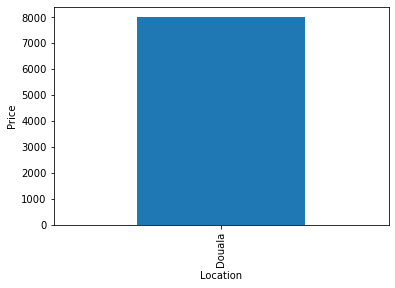

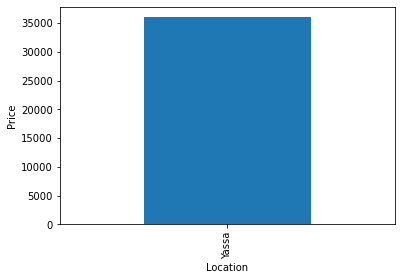

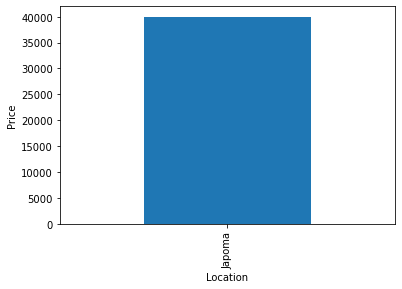

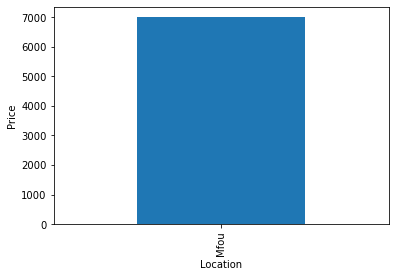

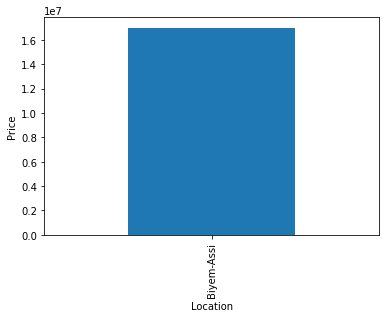

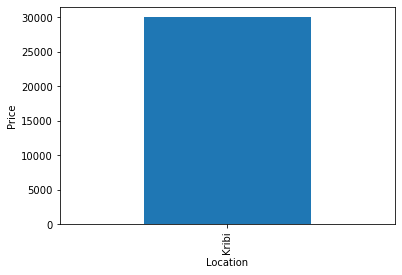

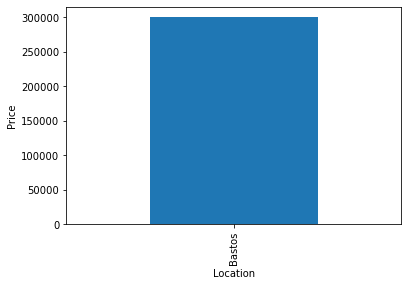

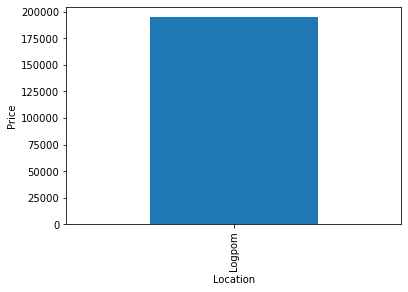

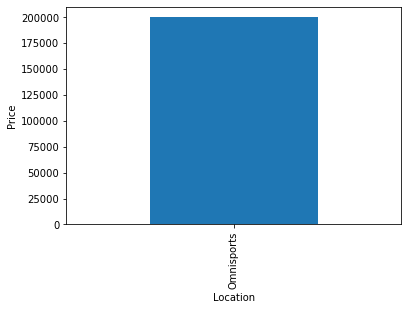

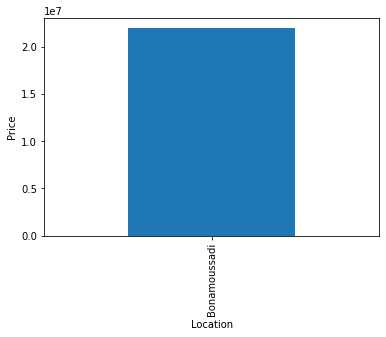

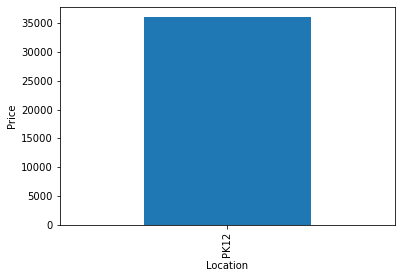

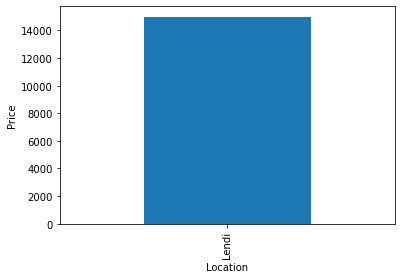

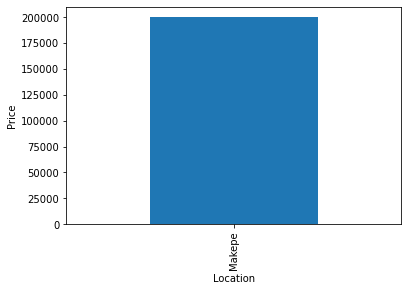

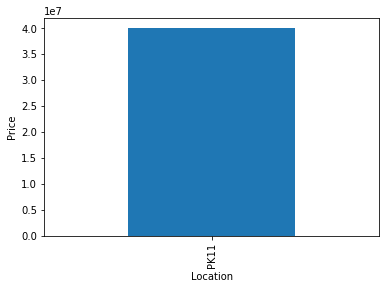

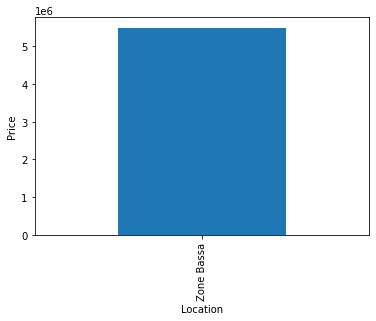

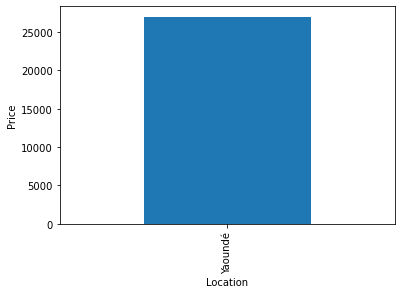

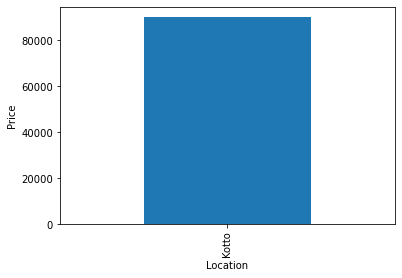

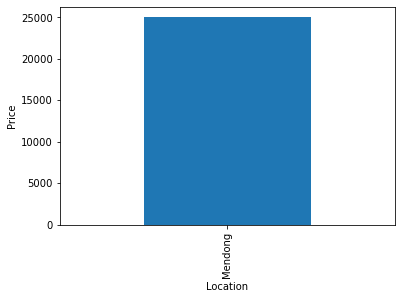

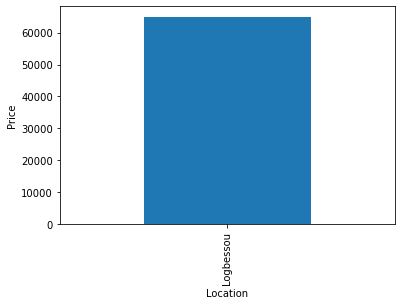

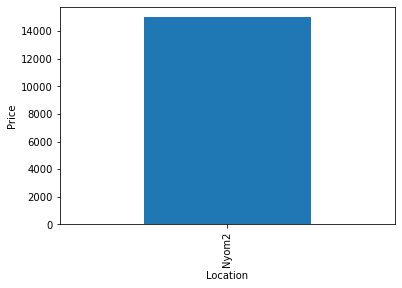

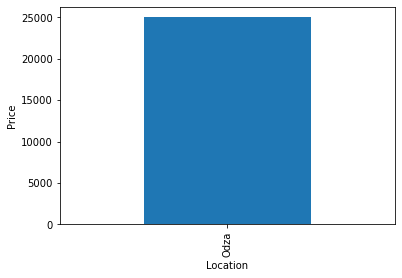

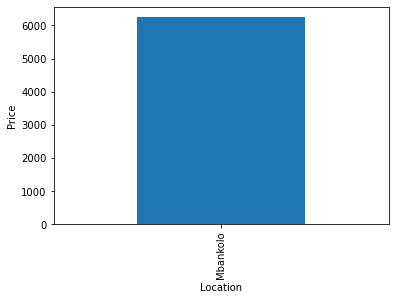

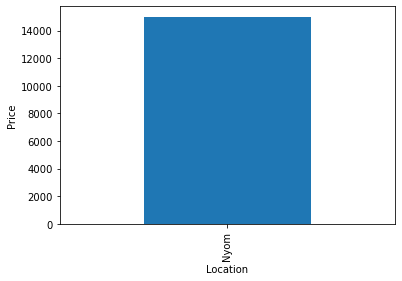

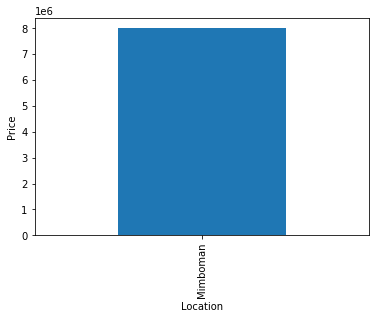

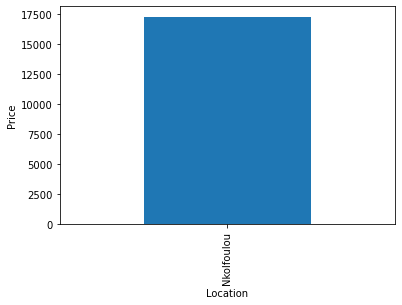

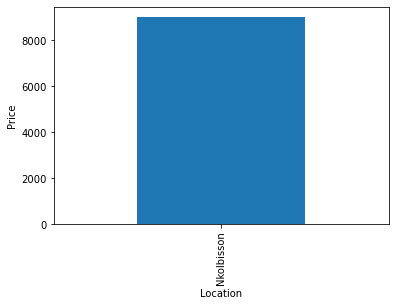

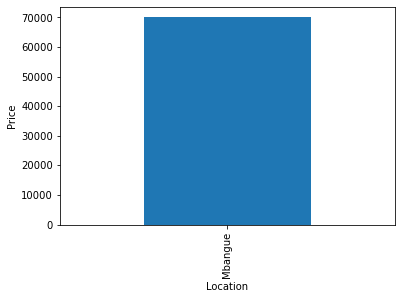

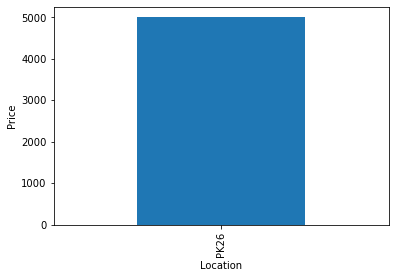

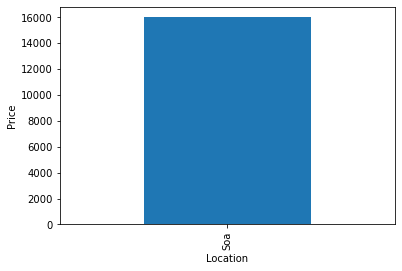

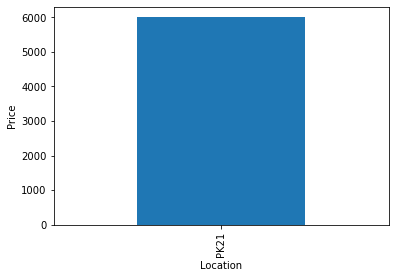

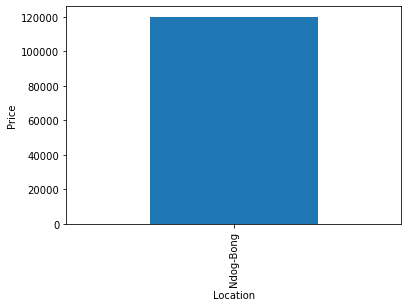

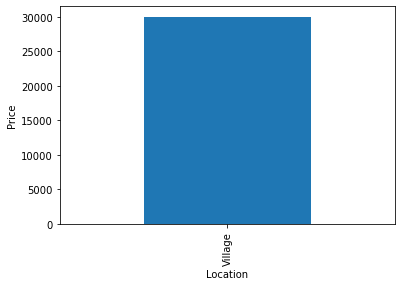

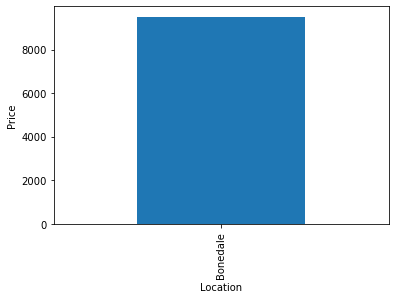

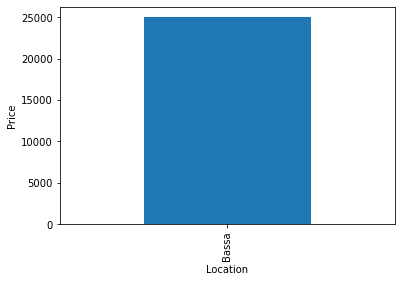

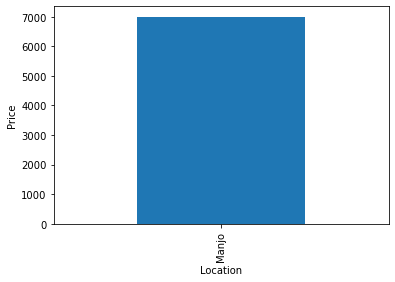

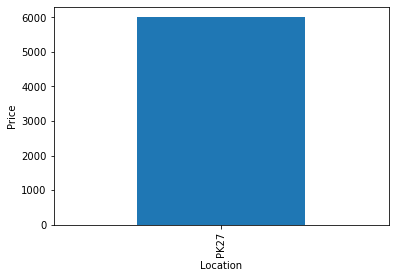

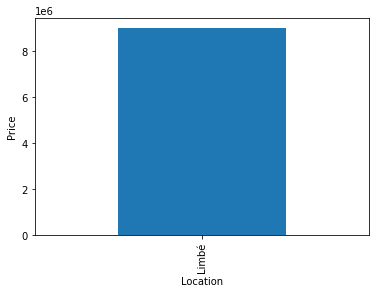

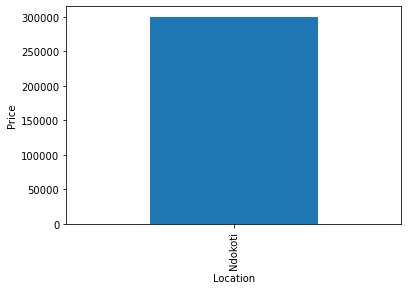

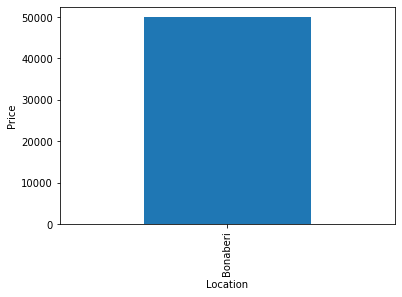

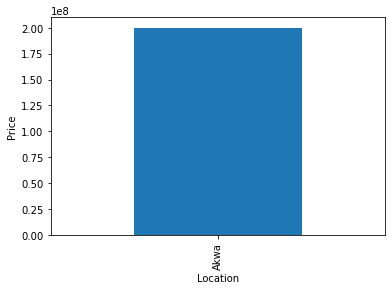

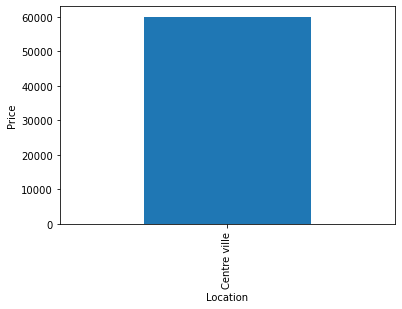

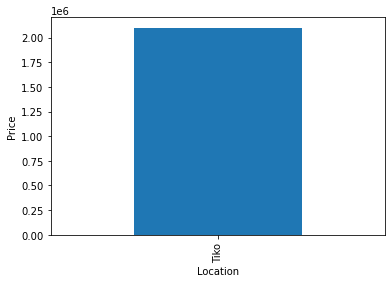

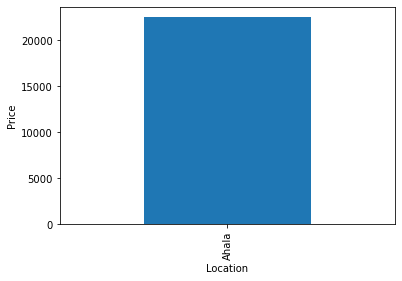

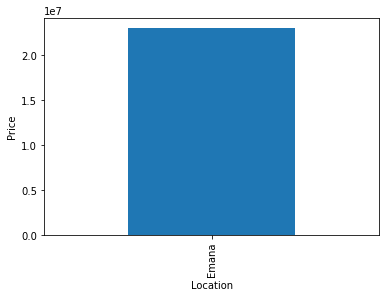

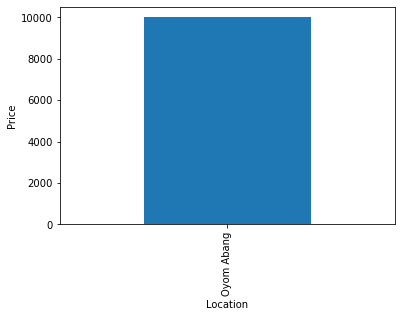

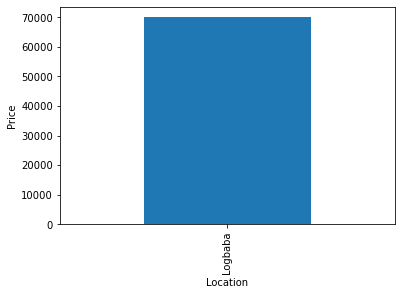

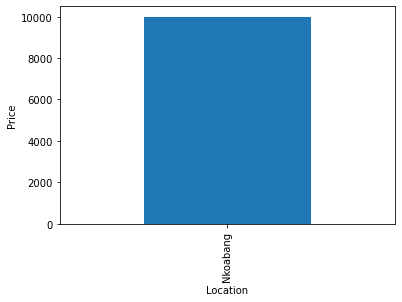

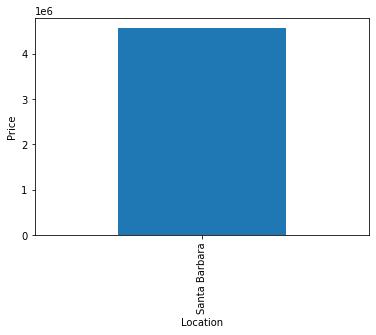

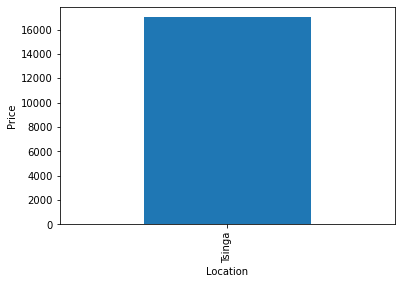

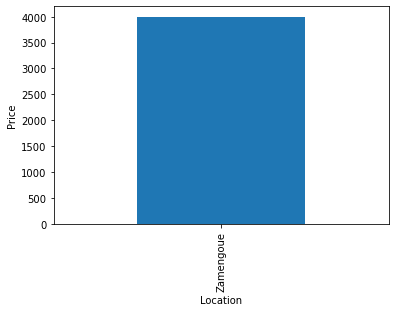

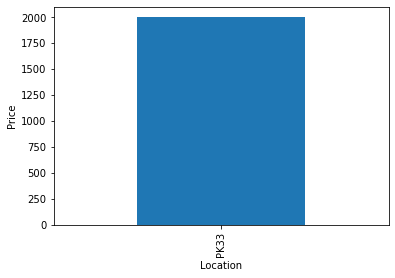

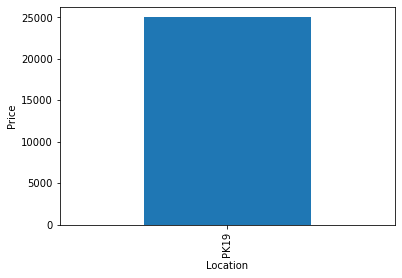

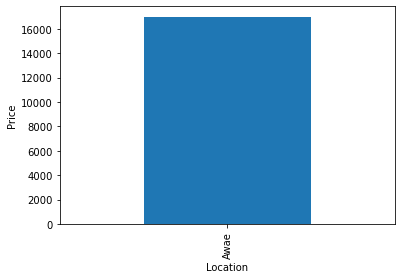

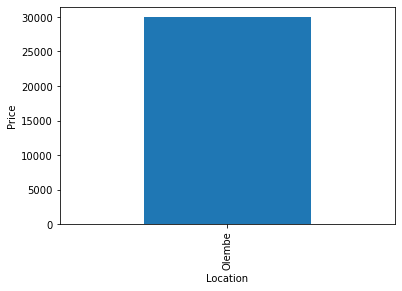

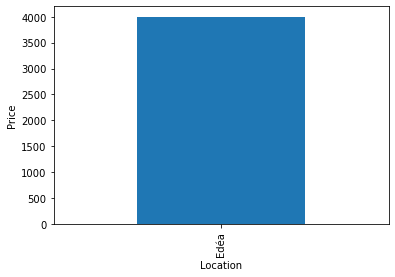

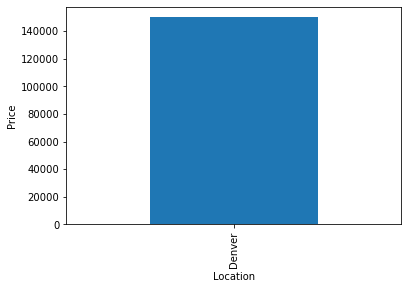

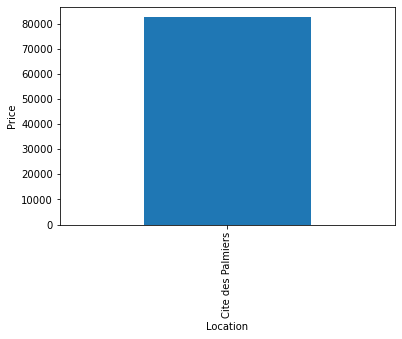

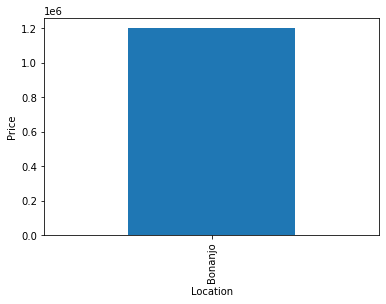

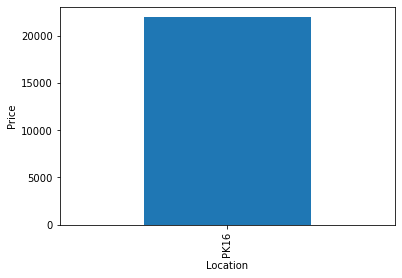

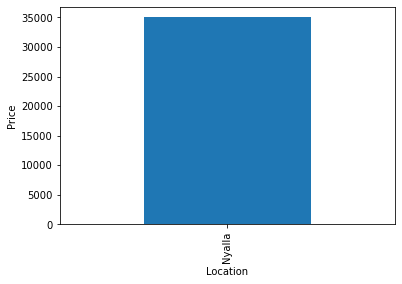

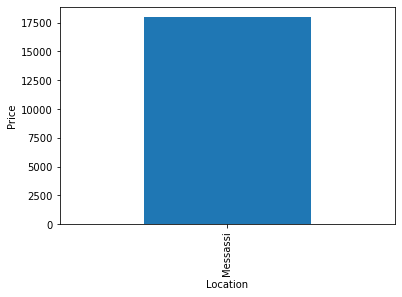

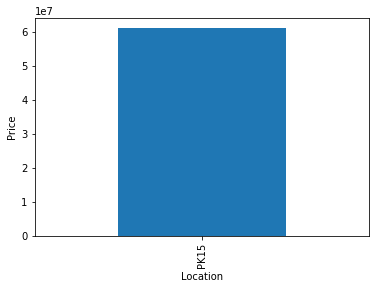

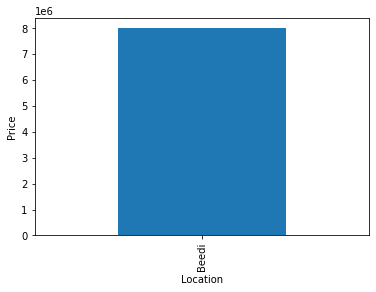

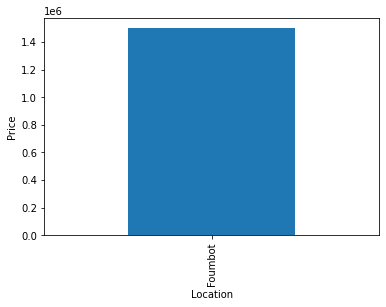

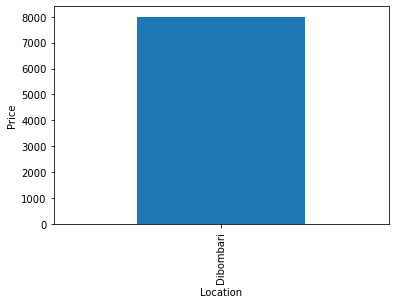

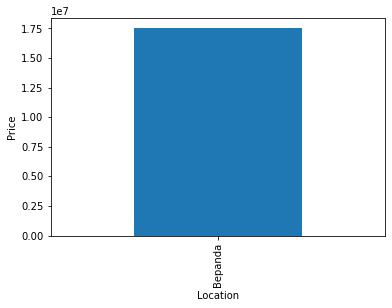

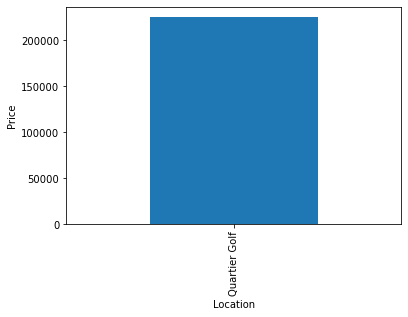

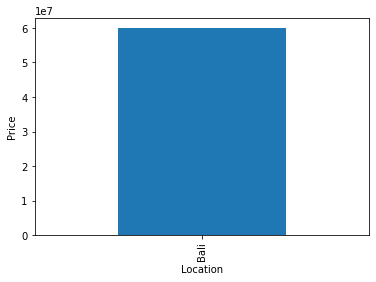

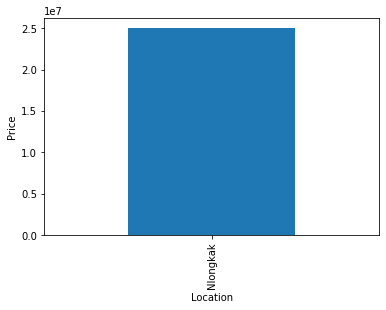

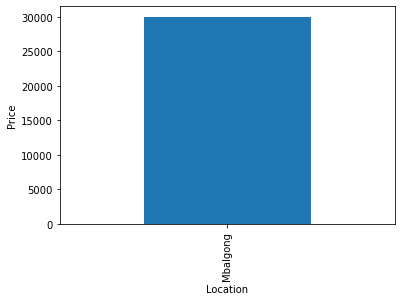

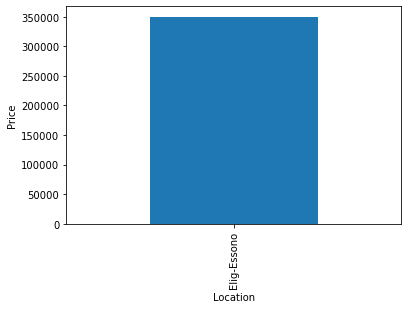

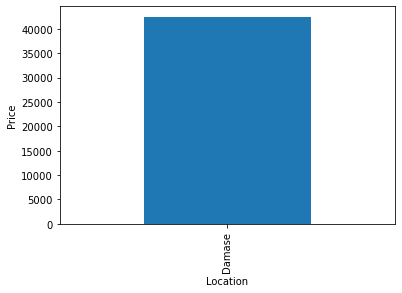

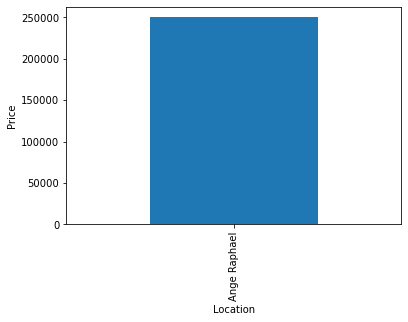

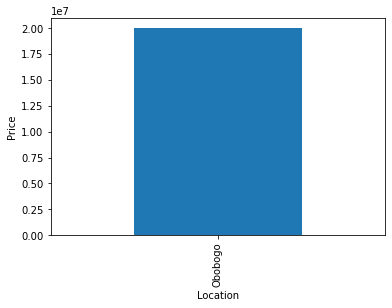

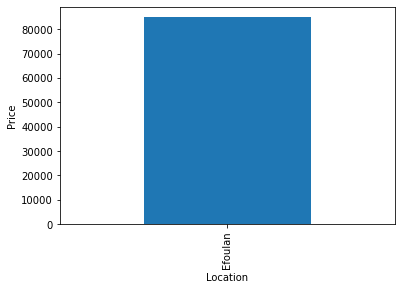

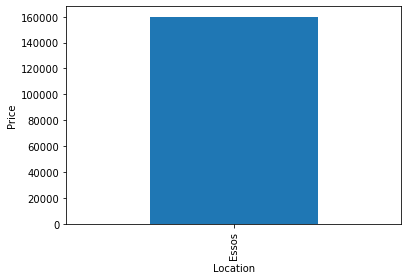

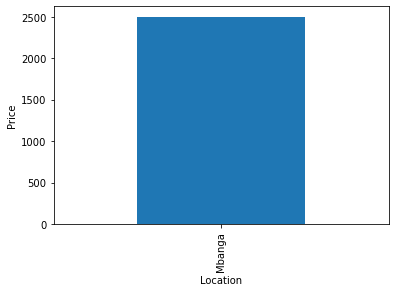

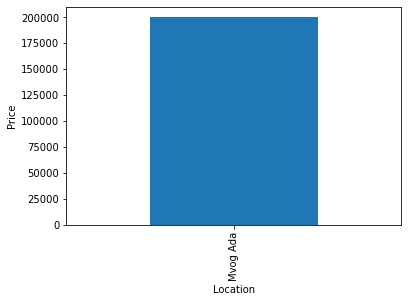

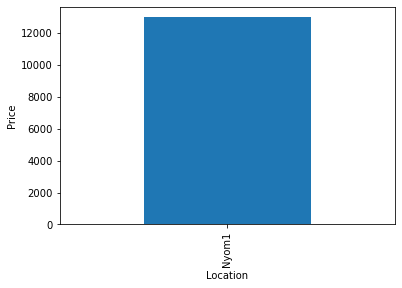

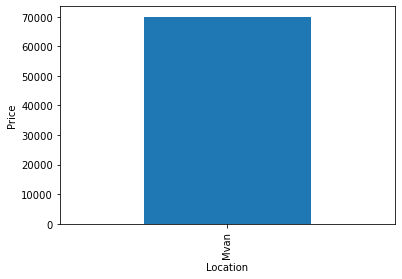

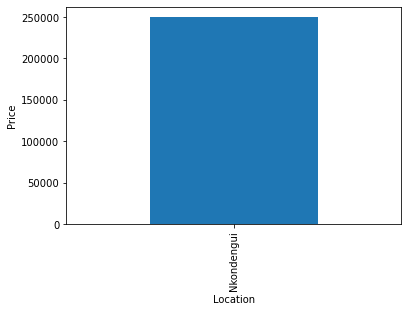

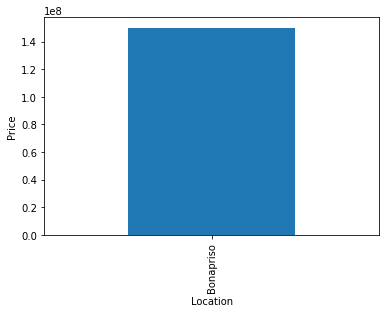

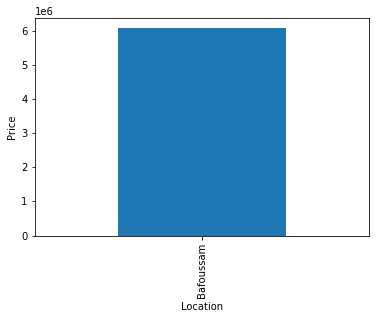

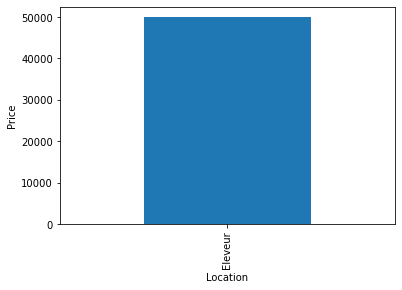

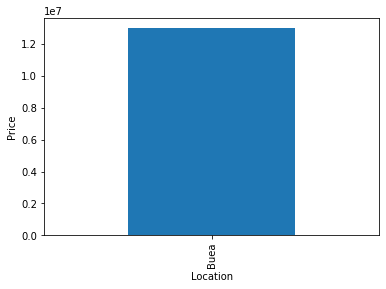

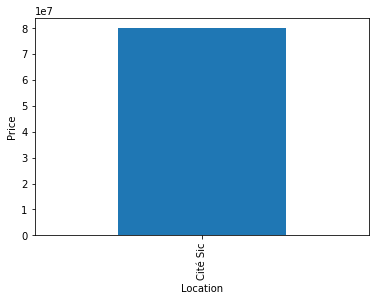

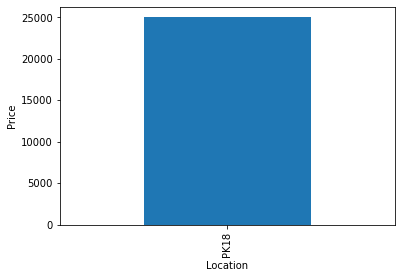

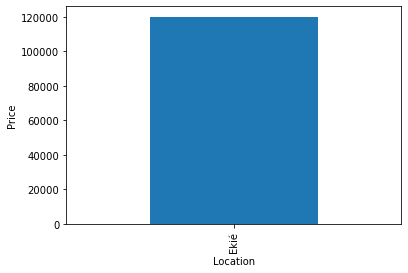

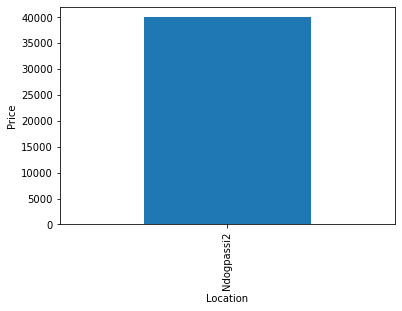

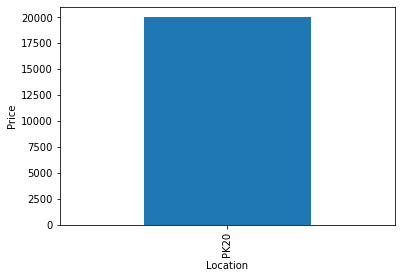

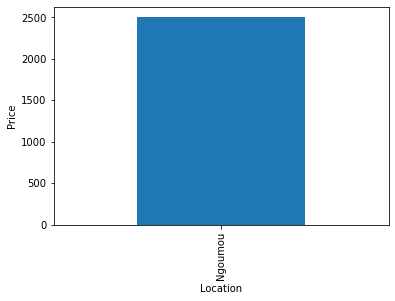

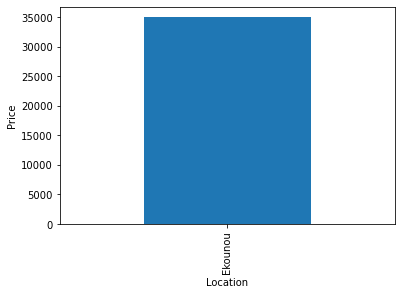

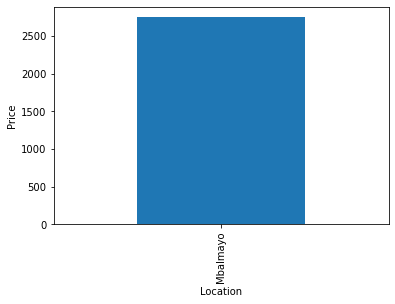

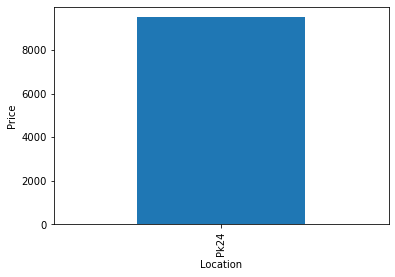

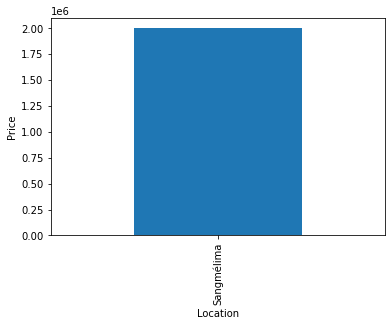

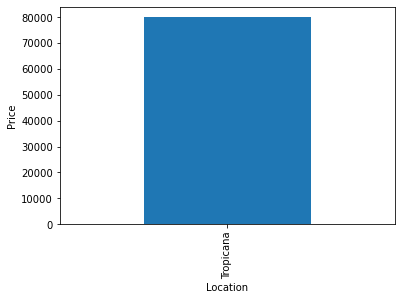

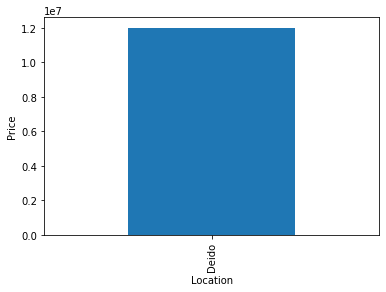

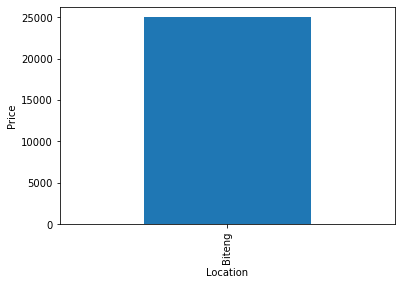

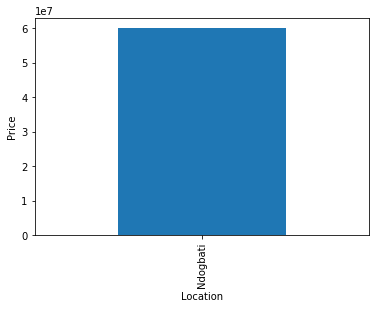

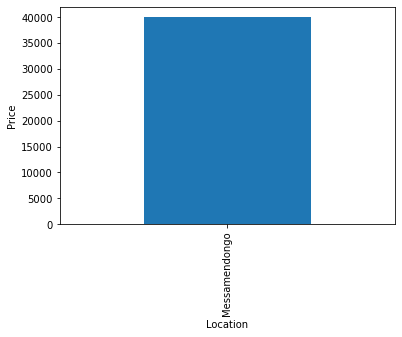

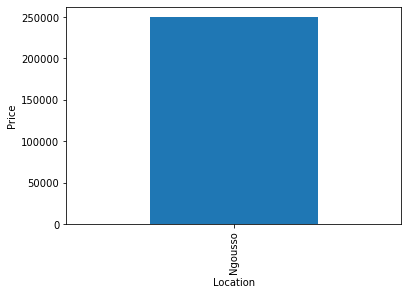

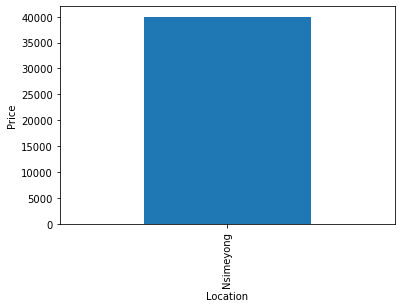

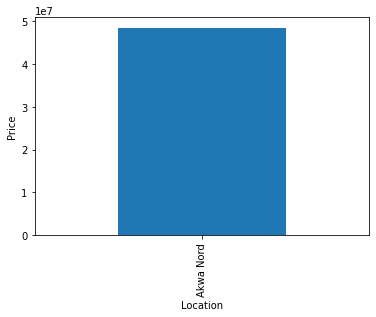

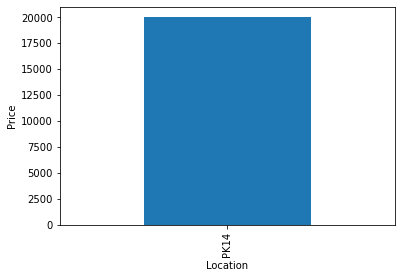

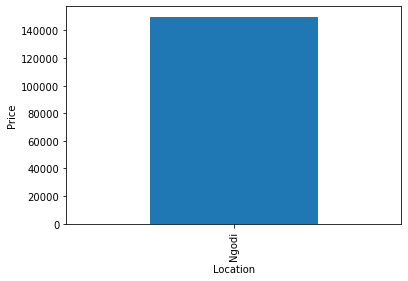

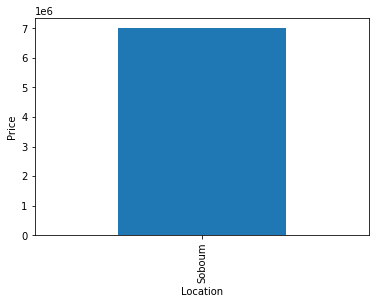

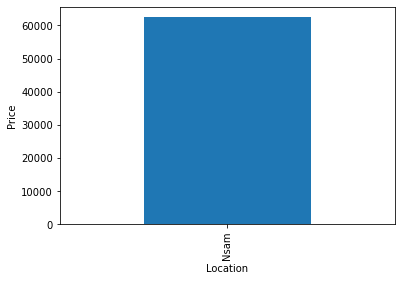

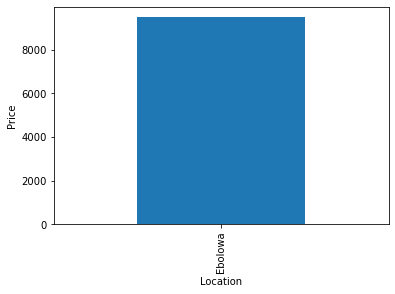

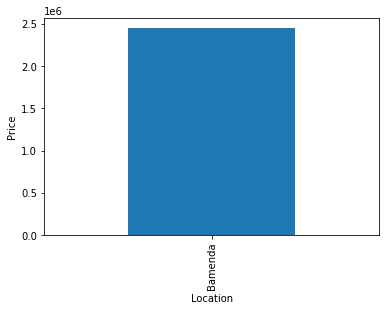

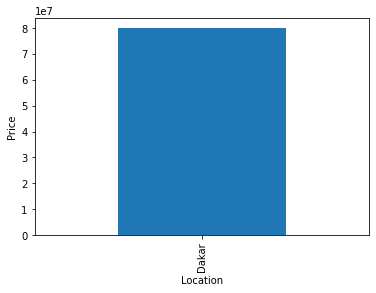

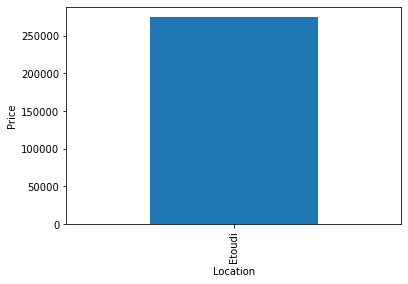

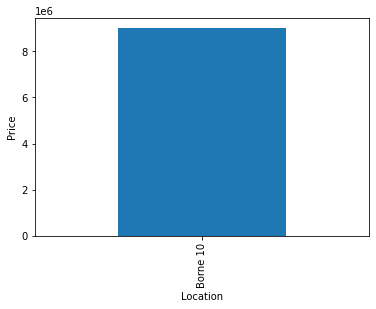

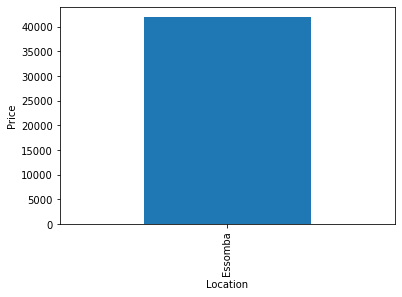

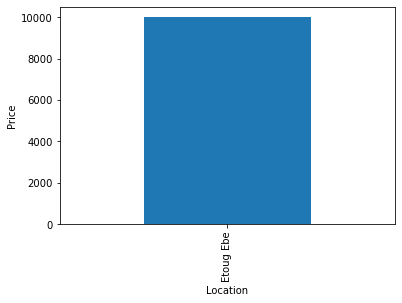

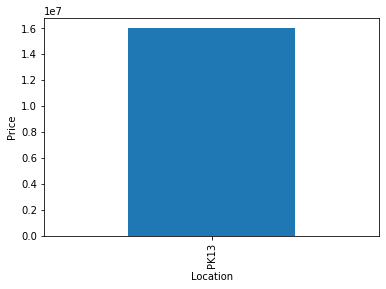

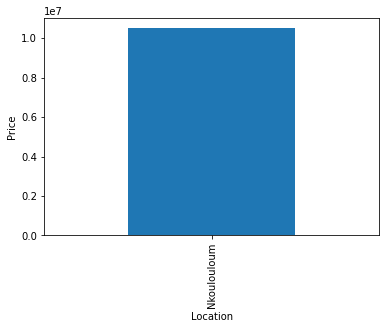

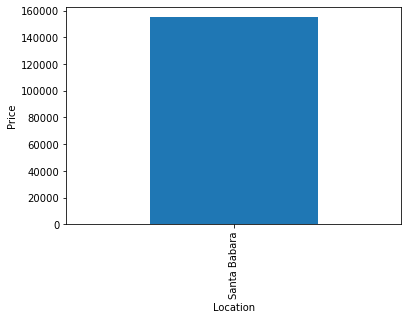

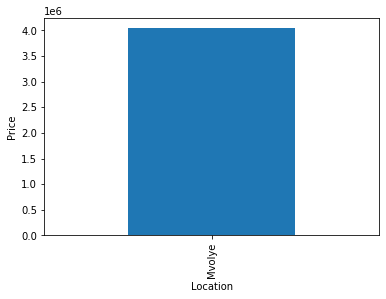

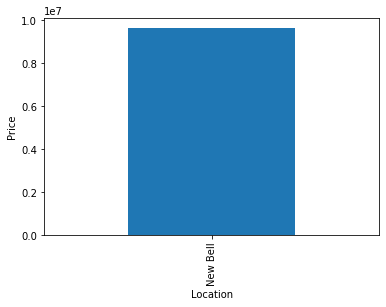

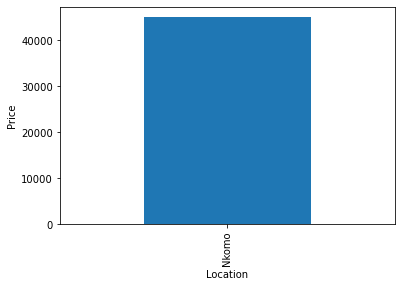

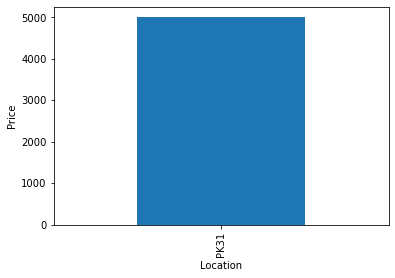

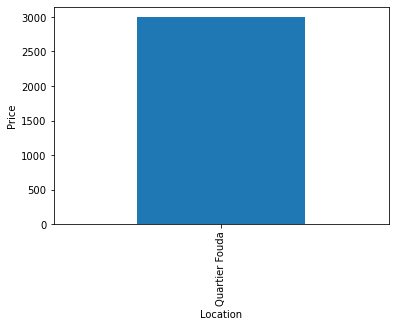

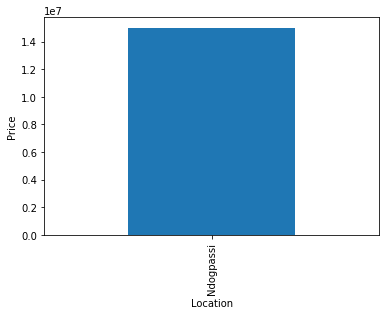

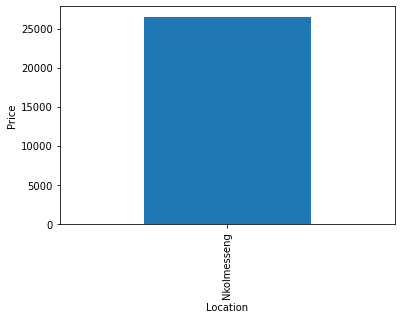

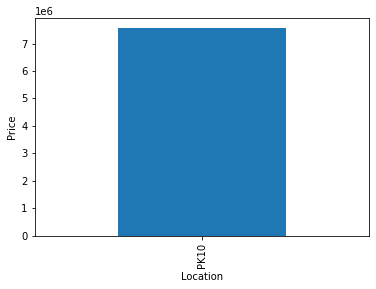

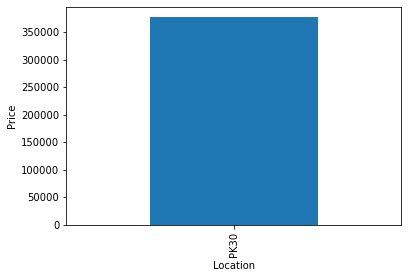

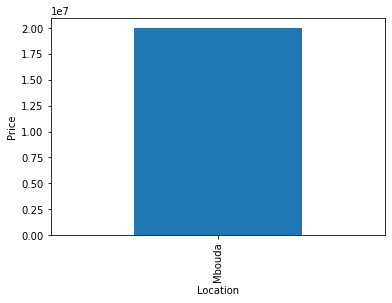

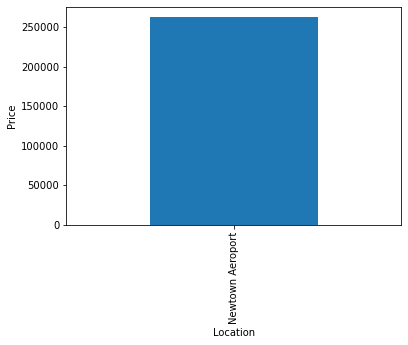

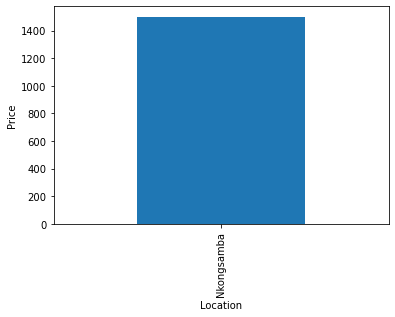

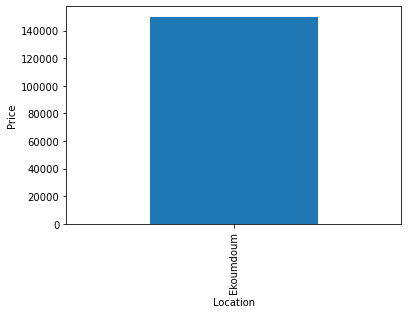

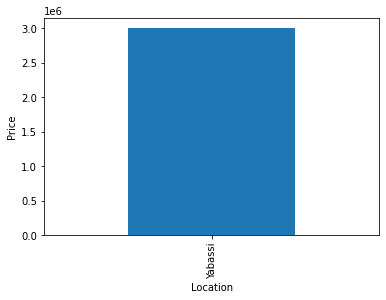

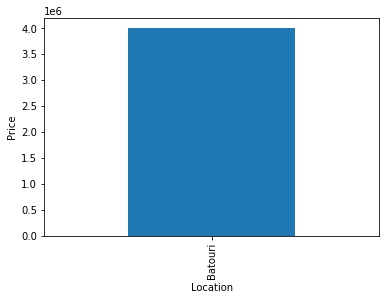

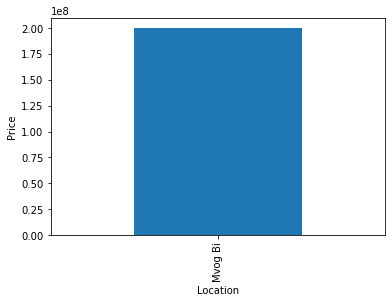

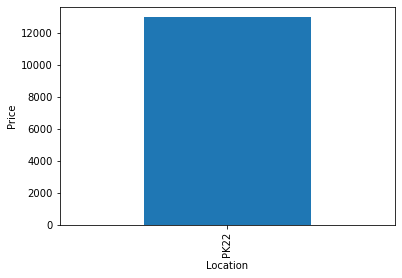

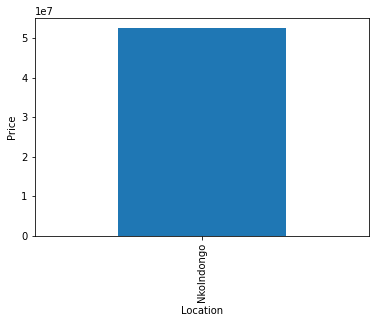

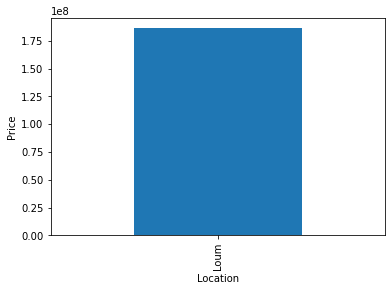

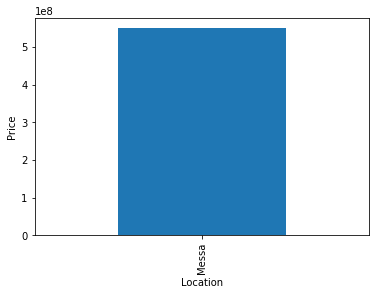

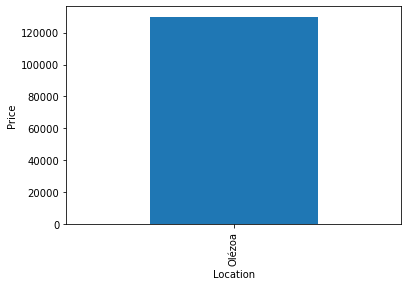

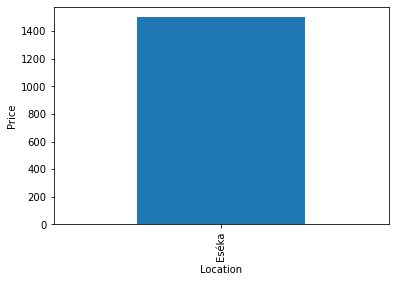

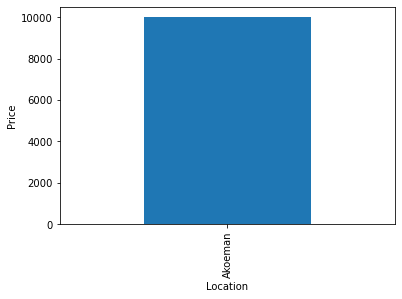

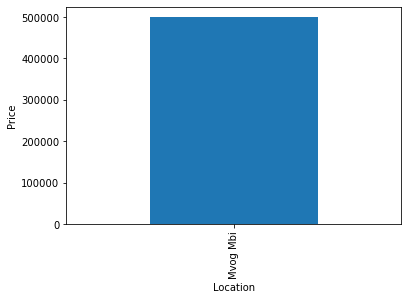

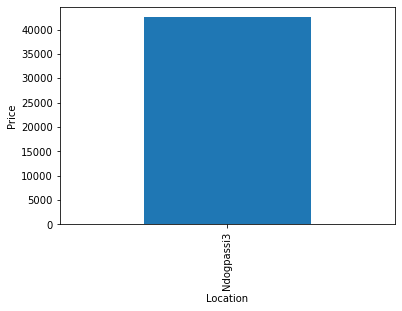

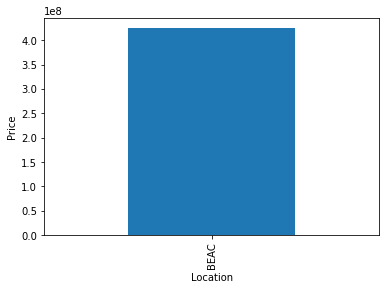

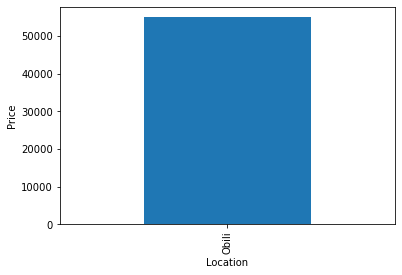

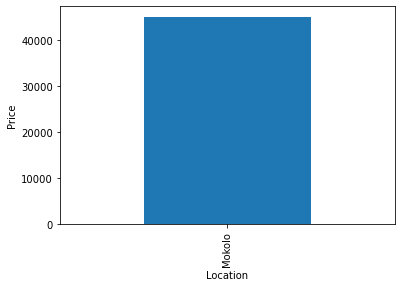

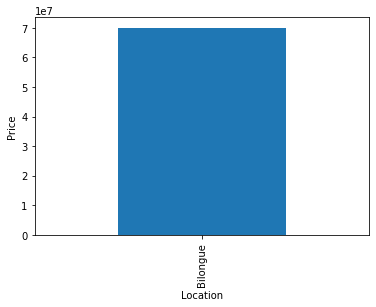

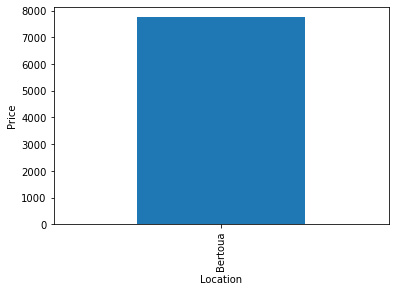

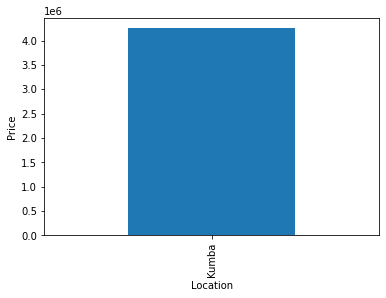

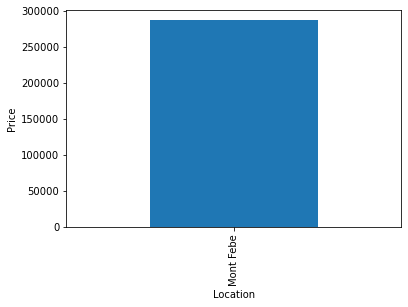

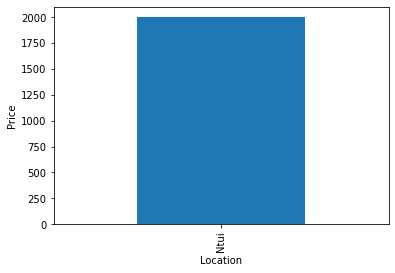

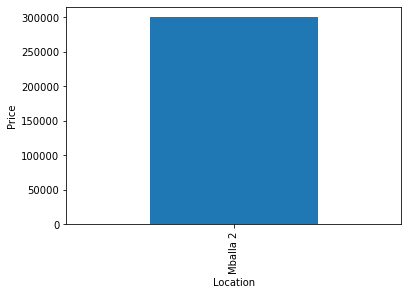

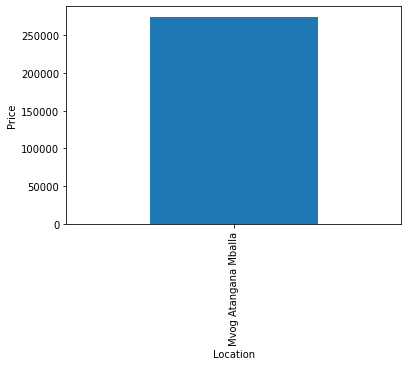

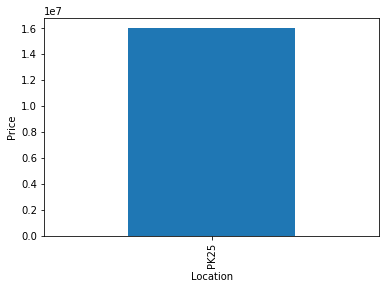

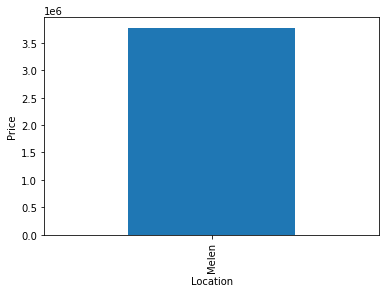

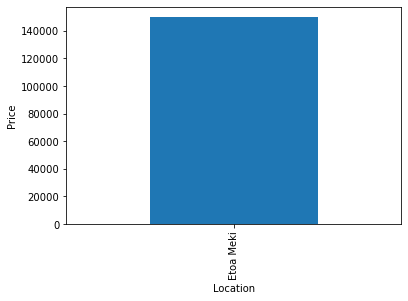

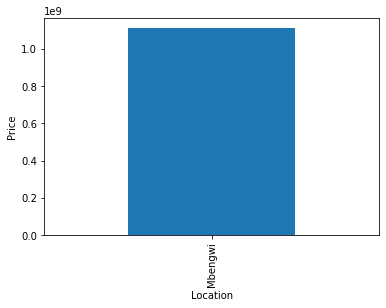

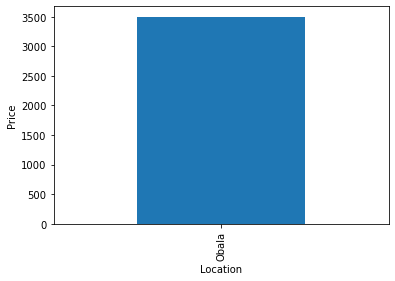

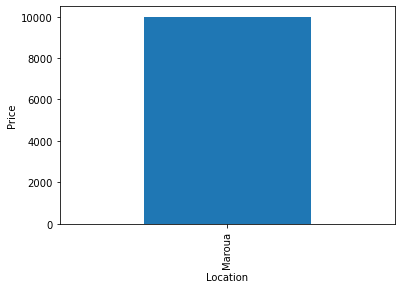

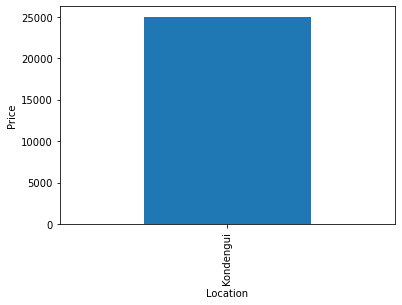

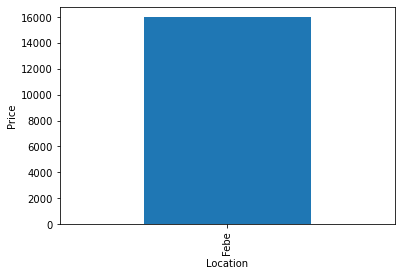

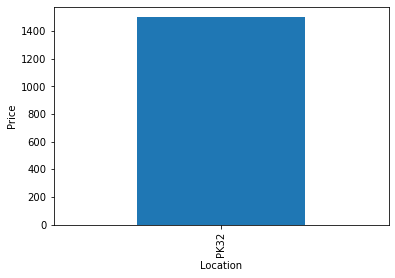

In [200]:
#Plotting bar charts for all the locations against the median price
data = dataset.copy()
data['Price per Area'] = data['Price']/data['Area']
for location in location_list:
    data = dataset.copy()
    data = data[data.Location == location]
    data.groupby('Location')['Price'].median().plot.bar()
    plt.ylabel('Price')
    plt.show()

Despite the fact that we are plotting Locatin against Median Prices, we still see Locations like "Biyem-Assi" and "Bonamoussadi" returning very high values for the "Price". If we remove neighbouhoods which are not up to 1%, and take care of the outliers, these will be ok.

In [34]:
#Checking for rare categories in Locations
temp = data.groupby('Location')['Price'].count()/len(data)
temp_df = temp[temp>0.01].index

In [35]:
data['Location'] = np.where(data['Location'].isin(temp_df),dataset['Location'],'Rare Quartier')
print(data['Location'].unique())

['Douala' 'Yassa' 'Japoma' 'Mfou' 'Rare Quartier' 'Kribi' 'Bastos'
 'Logpom' 'Bonamoussadi' 'PK12' 'Lendi' 'Makepe' 'Yaoundé' 'Kotto'
 'Logbessou' 'Odza' 'Soa' 'PK21' 'Village' 'Limbé' 'Bonaberi' 'Nkoabang'
 'PK16' 'Bonapriso']


We see that "Bonamoussadi" is among the rare neighbourhoods